# Set up

Import packages

In [1]:
# Import required packages
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV3Large, NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from shutil import copyfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random 
from google.colab import drive

Load data

In [2]:
# Load data
file_url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
zip_dir = tf.keras.utils.get_file('food-101.tar.gz', origin=file_url, extract=True)

4996292608/4996278331 [==============================] - 192s 0us/step


Sort and copy files into train and test splits

In [3]:
# Get list of train and test images from train.txt and test.txt respectively
with open('/root/.keras/datasets/food-101/meta/train.txt', 'r') as txt:
  train_list = [read.strip() for read in txt.readlines()]
with open('/root/.keras/datasets/food-101/meta/test.txt', 'r') as txt:
  test_list = [read.strip() for read in txt.readlines()]

# Create training_set and testing_set variables which will take the filepaths for the images for each set
training_set = ['/root/.keras/datasets/food-101/images/' + item.strip() + '.jpg' for item in train_list]
testing_set = ['/root/.keras/datasets/food-101/images/' + item.strip() + '.jpg' for item in test_list]

# Shuffle the list of images using the random package
shuffled_training_set = random.sample(training_set, len(training_set))

# Create total_train and total_val variables which will take the value for the lenth of training_set or testing_set
total_train = len(shuffled_training_set)
total_val = len(testing_set)

# Create batch_size variable and assign the value 32
batch_size = 32

# Function to copy images from training_set and testing_set to a given input path and folder
def copy_files_to_set(img_set, input_path, set_name):
  for filename in img_set:
    this_file = filename.split('/')[-1]
    target = filename.split('/')[-2]
    folder = input_path + '/' + set_name + '/' + target
    os.makedirs(folder, exist_ok = True)
    destination = folder + '/' + this_file
    copyfile(filename, destination)

# Assign chosen input path to variable input_path
input_path = '/root/.keras/datasets/food101'

# Copy images from training_set and testing_set to given destination
copy_files_to_set(img_set=shuffled_training_set, input_path=input_path, set_name='training')
copy_files_to_set(img_set=testing_set, input_path=input_path, set_name='test')

Define functions for plots

In [4]:
# Function to plot the accuracy curve
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    # Min and mix y axis limits defined to allow for easy comparison between models
    plt.ylim(0,1)
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

# Function to plot the loss curve
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # Min and mix y axis limits defined to allow for easy comparison between models
    plt.ylim(0.5, 4)
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()


# Modelling

## Inception model

Prepare data for modelling

In [5]:
# Create an image generator for the training set
train_img_gen = ImageDataGenerator(
    # Rescale to between 0-1
    rescale=1. / 255,
    # Add augmentations to data
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Create an image generator for the test set
test_img_gen = ImageDataGenerator(rescale = 1. / 255)

# Create a data generator for the training set using flow_from_directory()
train_data_gen = train_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=input_path+'/training', 
    target_size=(299, 299), 
    class_mode='categorical', 
    color_mode='rgb')
# Create a data generator for the test set using flow_from_directory()
test_data_gen = test_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=input_path+'/test', 
    target_size=(299, 299), 
    class_mode='categorical', 
    color_mode='rgb')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Create base model, freeze layers, build model, compile model, define call backs, and fit the model

In [ ]:
# Instantiate a pre-trained InceptionResNetV2 model
inception = tf.keras.applications.InceptionResNetV2(
    # Specify the input image dimensions
    input_shape = (299, 299, 3),
    # Don't include top layers as this project has a different number of classes than the pre-trained model
    include_top = False, 
    # Use pre-trained weights from ImageNet
    weights = 'imagenet')

# Freeze layers
inception.trainable = False

# Build model
model = tf.keras.Sequential([
    inception,
    # Global average layer
    GlobalAveragePooling2D(),
    # First and second fully connected layers, with relu activation function
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Third fully connected layer, with softmax activation function for making predictions
    Dense(101, activation='softmax')
])

# Set optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)
# Compile model using catgorical crossentropy as the loss function, adam as the optimizer, and accuray as the metric
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
# Save the model to the temp folder of Google Drive (mount drive, select directory)
drive.mount('/content/drive')
MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "inception-model-{epoch:02d}.h5"), save_best_only=True) 

# Fit the model
history = model.fit(
    train_data_gen,
    steps_per_epoch = total_train // batch_size,
    validation_data = test_data_gen,
    validation_steps = total_val // batch_size,
    epochs = 10,
    callbacks = [early_stop_cb, reduce_lr, model_checkpoint_cb])

Plot accuracy and loss curves for model

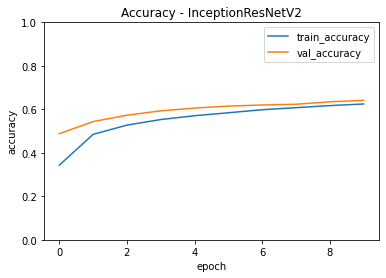

In [ ]:
# Plot the train and validation accuracy for the model
plot_accuracy(history,'Accuracy - InceptionResNetV2')

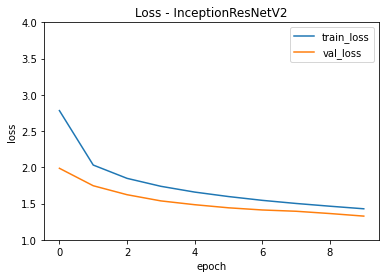

In [ ]:
# Plot the train and validation loss for the model
plot_loss(history,'Loss - InceptionResNetV2')

## MobileNetV3 Model

Prepare data for modelling

In [7]:
# Create an image generator for the training set - don't need to sclae the images for MobileNet
mobile_train_img_gen = ImageDataGenerator(
    # Add augmentations to data
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Create an image generator for the test set - don't need to sclae the images for MobileNet
mobile_test_img_gen = ImageDataGenerator()

# Create a data generator for the training set using flow_from_directory()
mobile_train_data_gen = mobile_train_img_gen.flow_from_directory(
    batch_size = batch_size, 
    directory = input_path+'/training', 
    target_size = (224, 224), 
    class_mode = 'categorical', 
    color_mode = 'rgb')
# Create a data generator for the test set using flow_from_directory()
mobile_test_data_gen = mobile_test_img_gen.flow_from_directory(
    batch_size = batch_size, 
    directory = input_path+'/test', 
    target_size = (224, 224), 
    class_mode = 'categorical', 
    color_mode = 'rgb')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


Create base model, freeze layers, build model, compile model, define call backs, and fit the model

In [ ]:
# Instantiate a pre-trained MobileNetV3Large model
mobile = tf.keras.applications.MobileNetV3Large(
    # Specify the input image dimensions
    input_shape=(224, 224, 3),
    # Don't include top layers as this project has a different number of classes than the pre-trained model
    include_top=False,
    # Use pre-trained weights from ImageNet
    weights='imagenet',
    # Include pre-processing
    include_preprocessing=True)

# Freeze layers
mobile.trainable = False

# Build model
mobile_model = tf.keras.Sequential([
    mobile,
    # Global average layer
    GlobalAveragePooling2D(),
    # First and second fully connected layers, with relu activation function
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Third fully connected layer, with softmax activation function for making predictions
    Dense(101, activation='softmax')
])

# Set optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)
# Compile model using catgorical crossentropy as the loss function, adam as the optimizer, and accuray as the metric
mobile_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
# Save the model to the temp folder of Google Drive (mount drive, select directory)
drive.mount('/content/drive')
MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "mobile-model-{epoch:02d}.h5"), save_best_only=True) 

# Fit the model
mobile_history = mobile_model.fit_generator(
    mobile_train_data_gen,
    steps_per_epoch = total_train // batch_size,
    validation_data = mobile_test_data_gen,
    validation_steps = total_val // batch_size,
    epochs = 10,
    callbacks = [early_stop_cb, reduce_lr, checkpoint])

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
2367/2367 [==============================] - 1436s 601ms/step - loss: 2.7245 - accuracy: 0.3592 - val_loss: 1.6717 - val_accuracy: 0.5634 - lr: 1.0000e-04
Epoch 2/10
2367/2367 [==============================] - 1385s 585ms/step - loss: 1.8257 - accuracy: 0.5371 - val_loss: 1.4190 - val_accuracy: 0.6212 - lr: 1.0000e-04
Epoch 3/10
2367/2367 [==============================] - 1304s 551ms/step - loss: 1.6344 - accuracy: 0.5796 - val_loss: 1.2939 - val_accuracy: 0.6488 - lr: 1.0000e-04
Epoch 4/10
2367/2367 [==============================] - 1326s 560ms/step - loss: 1.5282 - accuracy: 0.6038 - val_loss: 1.2553 - val_accuracy: 0.6572 - lr: 1.0000e-04
Epoch 5/10
2367/2367 [==============================] - 1329s 562ms/step - loss: 1.4538 - accuracy: 0.6206 - val_loss: 1.2068 - val_accuracy: 0.6727 - lr: 1.0000e-04
Epoch 6/10
2367/2367 [==============================] - 1310s 553ms/step - loss: 1.3972 - accuracy: 0.6365 - val_loss: 1.1746 - val_accuracy: 0.6791 - lr: 1.0000e-04
Epoc

Plot accuracy and loss curves for model

In [ ]:
# Plot the accuracy curve of model
plot_accuracy(mobile_history,'Accuracy - MobileNetV3Large')

In [ ]:
# Plot the loss curve of model
plot_loss(mobile_history,'Loss - MobileNetV3Large')

## NASNet Model

Prepare data for modelling

In [ ]:
# Create an image generator for the training set (same as used in Inception model)
train_img_gen = ImageDataGenerator(
    # Rescale to be between 0-1
    rescale=1. / 255,
    # Add augmentations to data
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# Create an image generator for the test set (same as used in Inception model)
test_img_gen = ImageDataGenerator(rescale = 1. / 255)

# Create a data generator for the training set using flow_from_directory()
nasnet_train_data_gen = mobile_train_img_gen.flow_from_directory(
    batch_size = batch_size, 
    directory = input_path+'/training', 
    target_size = (224, 224), 
    class_mode = 'categorical', 
    color_mode = 'rgb')
# Create a data generator for the test set using flow_from_directory()
nasent_test_data_gen = mobile_test_img_gen.flow_from_directory(
    batch_size = batch_size, 
    directory = input_path+'/test', 
    target_size = (224, 224), 
    class_mode = 'categorical', 
    color_mode = 'rgb')

Create base model, freeze layers, build model, compile model, define call backs, and fit the model

In [ ]:
# Instantiate a pre-trained NASNetMobile model
nasnet = tf.keras.applications.NASNetMobile(
    # Specify the input image dimensions
    input_shape = (224, 224, 3),
    # Don't include top layers as this project has a different number of classes than the pre-trained model
    include_top = False, 
    # Use pre-trained weights from ImageNet
    weights = 'imagenet')

# Freeze layers
nasnet.trainable = False

# Build model
nasnet_model = tf.keras.Sequential([
    nasnet,
    # Global average layer
    GlobalAveragePooling2D(),
    # First and second fully connected layers, with relu activation function
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Third fully connected layer, with softmax activation function for making predictions
    Dense(101, activation='softmax')
])

# Set optimizer
optimizer = tf.keras.optimizers.Adam(0.0001)
# Compile model using catgorical crossentropy as the loss function, adam as the optimizer, and accuray as the metric
nasnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
# Save the model to the temp folder of Google Drive (mount drive, select directory)
drive.mount('/content/drive')
MODEL_DIR = "/content/drive/My Drive/temp"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_DIR, "nasnet-model-{epoch:02d}.h5"), save_best_only=True) 

# Fit the model
nasnet_history = nasnet_model.fit_generator(
    nasnet_train_data_gen,
    steps_per_epoch = total_train // batch_size,
    validation_data = nasnet_test_data_gen,
    validation_steps = total_val // batch_size,
    epochs = 10,
    callbacks = [early_stop_cb, reduce_lr, checkpoint])

Plot accuracy and loss curves for model

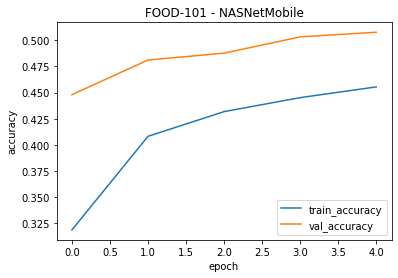

In [ ]:
# Plot the accuracy curve of model
plot_accuracy(nasnet_history,'FOOD-101 - NASNetMobile')

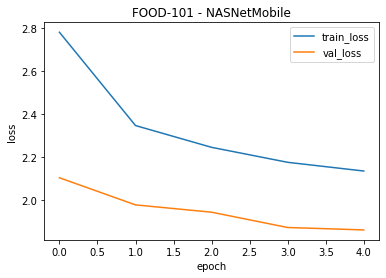

In [ ]:
# Plot the loss curve of model
plot_loss(nasnet_history,'FOOD-101 - NASNetMobile')